In [1]:
import numpy as np
import pandas as pd
import re
import os
import spacy

from collections import Counter
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

## Load data

In [2]:
glob('../data/news-summary-kaggle/*')

['../data/news-summary-kaggle/news_summary_more.csv',
 '../data/news-summary-kaggle/news-cleaned.csv',
 '../data/news-summary-kaggle/news_summary.csv']

In [3]:
data = pd.read_csv('../data/news-summary-kaggle/news_summary.csv', encoding='iso-8859-2')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
author       4514 non-null object
date         4514 non-null object
headlines    4514 non-null object
read_more    4514 non-null object
text         4514 non-null object
ctext        4396 non-null object
dtypes: object(6)
memory usage: 211.7+ KB


In [5]:
data.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
data_more = pd.read_csv('../data/news-summary-kaggle/news_summary_more.csv', encoding='iso-8859-2')

In [7]:
data_more.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
headlines    98401 non-null object
text         98401 non-null object
dtypes: object(2)
memory usage: 1.5+ MB


## Merge and filter data

In [8]:
raw_data = pd.DataFrame({
    'text': pd.concat([data.text, data_more.text], ignore_index=True),
    'summary': pd.concat([data.headlines, data_more.headlines], ignore_index=True)
})

In [9]:
raw_data.head()

,text,summary
0,The Administration of Union Territory Daman an...,Daman & Diu revokes mandatory Rakshabandhan in...
1,Malaika Arora slammed an Instagram user who tr...,Malaika slams user who trolled her for 'divorc...
2,The Indira Gandhi Institute of Medical Science...,'Virgin' now corrected to 'Unmarried' in IGIMS...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Aaj aapne pakad liya: LeT man Dujana before be...
4,Hotels in Maharashtra will train their staff t...,Hotel staff to get training to spot signs of s...


In [10]:
raw_data['text_len'] = raw_data.text.apply(lambda x: len(x))

In [11]:
raw_data['summary_len'] = raw_data.summary.apply(lambda x: len(x))

In [12]:
raw_data.text_len.hist(bins=50)

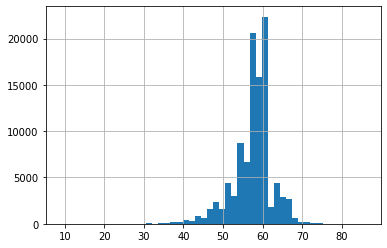

In [13]:
raw_data.summary_len.hist(bins=50)

In [14]:
{
    f'percentile {i}': f'summary length {np.percentile(raw_data.summary_len, i)}'
    for i in list(range(0, 6, 1)) + list(range(95, 100 + 1, 1))
}

{'percentile 0': 'summary length 9.0',
 'percentile 1': 'summary length 41.0',
 'percentile 2': 'summary length 44.0',
 'percentile 3': 'summary length 46.0',
 'percentile 4': 'summary length 47.0',
 'percentile 5': 'summary length 48.0',
 'percentile 95': 'summary length 65.0',
 'percentile 96': 'summary length 65.0',
 'percentile 97': 'summary length 66.0',
 'percentile 98': 'summary length 67.0',
 'percentile 99': 'summary length 68.0',
 'percentile 100': 'summary length 86.0'}

In [15]:
raw_data = raw_data[raw_data.summary_len > raw_data.summary_len.quantile(.01)]

In [16]:
nlp = spacy.load('en', disable=['ner', 'parser'])

In [17]:
# nlp = spacy.load('pl_spacy_model')

In [18]:
def spacy_strip(row, is_summary=False):
    row=re.sub("(\\t)", ' ', str(row))
    row=re.sub("(\\r)", ' ', str(row))
    row=re.sub("(\\n)", ' ', str(row))

    row=re.sub("(__+)", ' ', str(row))
    row=re.sub("(-+)", ' ', str(row))
    row=re.sub("(~~+)", ' ', str(row))
    row=re.sub("(\+\++)", ' ', str(row))
    row=re.sub("(\.\.+)", ' ', str(row))

    row=re.sub("(\.\s+)", ' ', str(row))
    row=re.sub("(\-\s+)", ' ', str(row))
    row=re.sub("(\:\s+)", ' ', str(row))

    row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", '', str(row))

    parsed = nlp(row)
    lemmatized = ''
    for sentence in parsed:
        lemmatized += sentence.lemma_.strip() + ' '
    lemmatized = lemmatized.lstrip().rstrip()
    if is_summary:
        return '<START> ' + lemmatized + ' <END>' 
    return lemmatized

In [289]:
raw_data['text_stripped'] = [
    spacy_strip(row) for row in tqdm_notebook(raw_data.text)
]

  3%|▎         | 2954/101873 [00:30<06:31, 252.38it/s]

In [291]:
raw_data['text_cleaned'] = [
    str(doc) for doc in tqdm_notebook(nlp.pipe(raw_data['text_stripped'], batch_size=5000, n_threads=-1))
]

In [290]:
raw_data['summary_stripped'] = [
    spacy_strip(row, True) for row in tqdm_notebook(raw_data.summary)
]

In [292]:
raw_data['summary_cleaned'] = [
    str(doc)
    for doc in tqdm_notebook(nlp.pipe(raw_data['summary_stripped'], batch_size=5000, n_threads=-1))
]

### Load already filtered data

In [19]:
# raw_data.to_csv('../data/news-summary-kaggle/news-cleaned.csv')
raw_data = pd.read_csv('../data/news-summary-kaggle/news-cleaned.csv')

In [20]:
def change(row):
    row = row.split(' ')
    result = ''
    for token in row:
        if token == '_START_':
            result += 'SOS_TOKEN' + ' '
        elif token == '_END_':
            result += 'EOS_TOKEN'
        else:
            result += token + ' '
    result.lstrip().rstrip()
    return result

In [21]:
raw_data['summary_stripped'] = [change(row) for row in tqdm_notebook(raw_data.summary_stripped)]

In [22]:
raw_data['summary_cleaned'] = [change(row) for row in tqdm_notebook(raw_data.summary_cleaned)]

In [23]:
raw_data

,Unnamed: 0,text,summary,text_len,summary_len,text_stripped,text_cleaned,summary_stripped,summary_cleaned
0,0,The Administration of Union Territory Daman an...,Daman & Diu revokes mandatory Rakshabandhan in...,358,60,the Administration of Union Territory Daman an...,the Administration of Union Territory Daman an...,SOS_TOKEN Daman Diu revoke mandatory Rakshaba...,SOS_TOKEN Daman Diu revoke mandatory Rakshaba...
1,1,Malaika Arora slammed an Instagram user who tr...,Malaika slams user who trolled her for 'divorc...,361,60,Malaika Arora slam an Instagram user who troll...,Malaika Arora slam an Instagram user who troll...,SOS_TOKEN Malaika slam user who troll -PRON- f...,SOS_TOKEN Malaika slam user who troll -PRON- f...
2,2,The Indira Gandhi Institute of Medical Science...,'Virgin' now corrected to 'Unmarried' in IGIMS...,398,52,the Indira Gandhi Institute of Medical Science...,the Indira Gandhi Institute of Medical Science...,SOS_TOKEN Virgin now correct to Unmarried in I...,SOS_TOKEN Virgin now correct to Unmarried in I...
3,3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Aaj aapne pakad liya: LeT man Dujana before be...,368,56,Lashkar e Taibas Kashmir commander Abu Dujana ...,Lashkar e Taibas Kashmir commander Abu Dujana ...,SOS_TOKEN Aaj aapne pakad liya LeT man Dujana ...,SOS_TOKEN Aaj aapne pakad liya LeT man Dujana ...
4,4,Hotels in Maharashtra will train their staff t...,Hotel staff to get training to spot signs of s...,366,60,hotel in Maharashtra will train -PRON- staff t...,hotel in Maharashtra will train -PRON- staff t...,SOS_TOKEN hotel staff to get training to spot ...,SOS_TOKEN hotel staff to get training to spot ...
5,5,A 32-year-old man on Wednesday was found hangi...,"Man found dead at Delhi police station, kin al...",347,60,a 32 year old man on Wednesday be find hang in...,a 32 year old man on Wednesday be find hang in...,SOS_TOKEN man find dead at Delhi police statio...,SOS_TOKEN man find dead at Delhi police statio...
6,6,The Delhi High Court reduced the compensation ...,Delhi HC reduces aid for 'negligent' accident ...,361,59,the Delhi High Court reduce the compensation a...,the Delhi High Court reduce the compensation a...,SOS_TOKEN Delhi HC reduce aid for negligent ac...,SOS_TOKEN Delhi HC reduce aid for negligent ac...
7,7,A 60-year old Dalit woman was allegedly lynche...,60-yr-old lynched over rumours she was cutting...,331,60,a 60 year old Dalit woman be allegedly lynch i...,a 60 year old Dalit woman be allegedly lynch i...,SOS_TOKEN 60 yr old lynch over rumour -PRON- b...,SOS_TOKEN 60 yr old lynch over rumour -PRON- b...
8,8,An inquiry by the Aircraft Accident Investigat...,Chopper flying critically low led to 2015 Bomb...,370,59,an inquiry by the Aircraft Accident Investigat...,an inquiry by the Aircraft Accident Investigat...,SOS_TOKEN chopper fly critically low lead to 2...,SOS_TOKEN chopper fly critically low lead to 2...
9,9,The Congress party has opened a bank called 'S...,Congress opens 'State Bank of Tomato' in Lucknow,311,48,the Congress party have open a bank call State...,the Congress party have open a bank call State...,SOS_TOKEN Congress open State Bank of Tomato i...,SOS_TOKEN Congress open State Bank of Tomato i...


## Prepare datasets

In [24]:
most_common_words = Counter()
for sent in tqdm_notebook(raw_data.text_cleaned):
    most_common_words.update(sent.split(' '))

In [25]:
most_common_words = sorted(most_common_words, key=most_common_words.get, reverse=True)
len(most_common_words), most_common_words[:10]

(101766, ['the', '-PRON-', 'be', 'to', 'a', 'in', 'of', 'and', 'have', '.'])

In [26]:
train_df, val_df = train_test_split(raw_data, test_size=0.3, random_state=9)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df.shape, val_df.shape

((71311, 9), (30562, 9))

In [28]:
PAD_TOKEN = 0
UNK_TOKEN = 1
START_TOKEN = 2
END_TOKEN = 3

In [514]:
class TextDataset(Dataset):
    def __init__(self, data, max_length=100, max_summary_length=25, word2idx=None, idx2word=None, max_vocab_size=50000):
        self.data = data
        self.max_length = max_length
        self.max_summary_length = max_summary_length
        if word2idx is None:
            self.words_counter = self.make_words_counter()
            self.word2idx, self.idx2word = self.make_vocab(self.words_counter, max_vocab_size)
        else:
            self.word2idx = word2idx
            self.idx2word = idx2word
        print('Dataset info:')
        print(f'Number of Tweets: {self.data.shape[0]}')
        print(f'Vocab Size: {len(self.word2idx)}')
        
    def __getitem__(self, index):
        text = self.data.text_stripped[index]
        summary = self.data.summary_stripped[index]
        x = self.get_vector(text)
        padded_x, len_x = self.pad_data(x, self.max_length)
        y = self.get_vector(summary)
        padded_y, len_y = self.pad_data(y, self.max_summary_length)
        return padded_x, padded_y, len_x, len_y
        
    def __len__(self):
        return len(self.data)
    
    def get_vector(self, text):
#         if type(text) is str:
        return [
            self.word2idx.get(token, UNK_TOKEN) for token in spacy_strip(text).split(' ')
        ]
#         elif type(text) is pd.Series:
#             for row in text
            
            
    
    def make_vocab(self, words_counter, max_vocab_size):
        word2idx = {
            '<PAD>': PAD_TOKEN,
            '<UNK>': UNK_TOKEN,
            'SOS_TOKEN': START_TOKEN,
            'EOS_TOKEN': END_TOKEN,
        }
        word2idx.update({
            word: i+4 for i, (word, count) in tqdm_notebook(
                enumerate(words_counter.most_common(max_vocab_size))
            )
        })
        idx2word = {
            idx: word for word, idx in tqdm_notebook(word2idx.items())
        }
        return word2idx, idx2word
    
    def make_words_counter(self):
        words_counter = Counter()
        for sent in tqdm_notebook(self.data.text_cleaned):
            words_counter.update(sent.split(' '))
        return words_counter
    
    def pad_data(self, x, max_length):
        padded_x = np.zeros((max_length,), dtype=np.int64)
        if len(x) > max_length:
            padded_x[:] = x[:max_length]
        else:
            padded_x[:len(x)] = x
        return padded_x, len(x)

In [515]:
max_text_words = max(raw_data.text_stripped.apply(lambda x: len(x.split(' '))))

In [516]:
max_summary_words = max(train_df.summary_stripped.apply(lambda x: len(x.split(' '))))

In [517]:
train_dataset = TextDataset(train_df, max_length=max_text_words, max_summary_length=max_summary_words, max_vocab_size=100000)


Dataset info:
Number of Tweets: 71311
Vocab Size: 85411


In [518]:
val_dataset = TextDataset(val_df, max_length=max_text_words, max_summary_length=max_summary_words)


Dataset info:
Number of Tweets: 30562
Vocab Size: 50004


In [519]:
vocabulary_size = len(train_dataset.idx2word)
vocabulary_size

85411

### Sanity check single text + text_indices + summary + summary_indices

In [520]:
def decode_text_from_sequence(sequence):
    text = ""
    for element in sequence:
        if type(element) is torch.Tensor:
            text += train_dataset.idx2word[element.item()] + ' '
        else:
            text += train_dataset.idx2word[element] + ' '
    return text

In [738]:
def indices_from_text(text, verbose=False):
    indices = []
    for word in spacy_strip(text).split(' '):
        if word == 'SOS_TOKEN' or '<START>':
            indices.append(START_TOKEN)
        elif word == 'EOS_TOKEN' or '<END>':
            indices.append(END_TOKEN)
        elif word == '<PAD>':
            indices.append(PAD_TOKEN)
        elif word == '<UNK>':
            indices.append(UNK_TOKEN)
        elif verbose:
            indices.append((train_dataset.word2idx[word], word))
        else: 
            indices.append(train_dataset.word2idx[word])
    return indices + [END_TOKEN]

## Create dataloaders

In [529]:
batch_size = 6

In [530]:
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

In [532]:
for batch_id, (text, summary, text_length, summary_length) in enumerate(train_data_loader):
    print(text.shape)
    break

torch.Size([6, 127])


In [535]:
def get_random_batch():
    batch_data = next(iter(train_data_loader))
    texts, summaries, text_length, summary_length = batch_data
    return texts, summaries, text_length, summary_length

In [537]:
batch_texts, batch_summaries, text_length, summary_length = get_random_batch()
batch_texts, batch_summaries, text_length, summary_length 

(tensor([[ 1123,   641,   169,    14,  1182,   317,  2201,     9,   650,    20,
              8,  2490,  2740,   596,   960,   218,    52,  1945,  1883,    14,
            133,    15,   614,     6,     4,   100,    25,   603,     4,  1115,
            100,   371,    50,     6,  2490,   121,     1,   121,    28,    10,
           1663,   107,     6,  8071,   728,     4,   564,    69,     4,    47,
              6,  3606,   121,     1,   121,     6,    34,  3606,    13,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,   

In [538]:
decode_text_from_sequence(batch_texts[0])

'describe recent attack on Hindi speak migrant in Gujarat as a dangerous trend West Bengal Chief Minister Mamata Banerjee on Tuesday say why be the BJP not control the situation BJP rule state be dangerous  <UNK>  add of course there be provocation behind the act all the people be scare  <UNK>  be also scare . <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> '

In [540]:
decode_text_from_sequence(batch_summaries[0])

'SOS_TOKEN BJP rule state dangerous Mamata after attack on migrant EOS_TOKEN <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> '

## Build a model

In [852]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, batch_size=128, n_layers=1, num_directions=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.num_directions = num_directions
        
        self.embedding = nn.Embedding(self.input_size, self.embedding_size)
        self.rnn = nn.GRU(self.embedding_size, self.hidden_size, num_layers=n_layers, dropout=self.dropout, 
                          bidirectional=True if self.num_directions > 1 else False)
        
    def forward(self, sequence, sequence_lengths, hidden=None):
        hidden = self.init_hidden()
        embedding_output = self.embedding(sequence) # max_text_len x batch_size x embedding_size
        embedding_output = nn.utils.rnn.pack_padded_sequence(embedding_output, sequence_lengths, enforce_sorted=False)
        encoder_output, hidden = self.rnn(embedding_output, hidden)
        encoder_output, output_lengths = nn.utils.rnn.pad_packed_sequence(encoder_output)
        # hidden: bidirectional x batch_size x hidden_size
        # output: max_text_len x batch_size x bidirectional * hidden_size

        encoder_output = encoder_output[:, :, :self.hidden_size] + encoder_output[:, :, self.hidden_size:]
        # output: max_text_len x batch_size x hidden_size
        return encoder_output, hidden
        
    def init_hidden(self):
        return torch.zeros(1 * self.num_directions, self.batch_size, self.hidden_size)

In [1019]:
class Attention(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'concat':
            self.attention = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, self.hidden_size))
            
    def forward(self, hidden, encoder_output):
        length = encoder_output.size(0)
        current_batch_size = encoder_output.size(1)
        attention_energy = torch.zeros(current_batch_size, length) # batch_size x max_text_length
        
        for b in range(current_batch_size):
            for i in range(length):
                attention_energy[b, i] = self.score(hidden[:, b], encoder_output[i, b].unsqueeze(0))
        
        return F.softmax(attention_energy).unsqueeze(1)
        
    def score(self, hidden, encoder_output):
        if self.method == 'concat':
            energy = self.attention(torch.cat((hidden, encoder_output), 1))
            energy = self.v.dot(energy)
            return energy

In [1041]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, batch_size=128, n_layers=1, num_directions=1, dropout=0.1):
        super(AttentionDecoderRNN, self).__init__()
        self.output_size = output_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.num_directions = num_directions
        
        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.encoder_dropout = nn.Dropout(self.dropout)
#         self.attention = Attention('concat', self.hidden_size)
        self.rnn = nn.GRU(self.embedding_size, self.hidden_size, num_layers=self.n_layers, dropout=self.dropout)
        self.output = nn.Linear(self.hidden_size, self.output_size)
        self.encoder_output = nn.Linear(self.hidden_size * self.num_directions, self.embedding_size)
        
    def forward(self, sequence, hidden, encoder_output):
        embedding_output = self.embedding(sequence).view(1, sequence.size(0), -1) 
        # n_layers x batch_size x embedding_size
        dropout_output = self.encoder_dropout(embedding_output) # n_layers x batch_size x hidden_size
        # hidden: 1 x batch_size x hidden_size
        
#         attention_weights = self.attention(hidden[-1], encoder_output)
#         context = attention_weights.bmm(encoder_output.transpose(0, 1)) # batch_size x 1 x hidden_size
#         context = context.transpose(0, 1) # 1 x batch_size x hidden_size
        
#         rnn_input = torch.cat((dropout_output, context), 2)
        decoder_output, hidden = self.rnn(dropout_output, hidden) # n_layers x batch_size x hidden_size

        decoder_output = decoder_output.squeeze(0) # output: batch_size x hidden_size
#         decoder_output = F.log_softmax(self.output(torch.cat((decoder_output, context), 1)))
        decoder_output = F.log_softmax(self.output(decoder_output))
        return decoder_output, hidden #, attention_weights

### Testing the models

In [1042]:
hidden_size = 5
embedding_size = 4
layers_number = 1

In [1043]:
encoder_test = EncoderRNN(vocabulary_size, embedding_size, hidden_size, batch_size=batch_size, num_directions=2, n_layers=layers_number)

In [1044]:
decoder_test = AttentionDecoderRNN(vocabulary_size, embedding_size, hidden_size, batch_size=batch_size, n_layers=layers_number)

In [1045]:
print(encoder_test)

EncoderRNN(
  (embedding): Embedding(85411, 4)
  (rnn): GRU(4, 5, dropout=0.1, bidirectional=True)
)


In [1046]:
print(decoder_test)

AttentionDecoderRNN(
  (embedding): Embedding(85411, 4)
  (encoder_dropout): Dropout(p=0.1, inplace=False)
  (rnn): GRU(4, 5, dropout=0.1)
  (output): Linear(in_features=5, out_features=85411, bias=True)
  (encoder_output): Linear(in_features=5, out_features=4, bias=True)
)


In [1047]:
def random_batch():
    batch_data = next(iter(train_data_loader))
    xs, ys, xs_length, ys_lengths = batch_data
    xs = xs.transpose(0, 1)
    ys = ys.transpose(0, 1)
    return xs, ys, xs_length, ys_lengths

In [1048]:
xs, ys, xs_length, ys_lengths = random_batch()

In [1049]:
xs.shape # max_text_len x batch_size 

torch.Size([127, 64])

In [1050]:
ys.shape # max_summary_len x batch_size 

torch.Size([19, 64])

In [1051]:
hidden = encoder_test.init_hidden()
hidden.shape # bidirectional x batch_size x hidden_size

torch.Size([2, 64, 5])

In [1052]:
encoder_output, encoder_hidden = encoder_test(xs, xs_length)

In [1053]:
print('ENC outputs', encoder_output.size()) # max_text_len x batch_size x hidden_size
print('ENC hidden', encoder_hidden.size()) # n_layers(1) * bidirectional x batch_size x hidden_size

ENC outputs torch.Size([89, 64, 5])
ENC hidden torch.Size([2, 64, 5])


In [1054]:
decoder_input = Variable(torch.LongTensor([START_TOKEN] * batch_size)) # START_TOKEN x batch_size
decoder_input

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [1055]:
decoder_hidden = encoder_hidden[:decoder_test.n_layers] # last forward hidden state from encoder

In [1056]:
all_outputs = Variable(torch.zeros(max_summary_words, batch_size, decoder_test.output_size))
all_outputs.shape

torch.Size([19, 64, 85411])

In [1057]:
torch.cat((torch.zeros(64), torch.zeros(5)))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [1058]:
decoder_output, decoder_hidden = decoder_test(
    decoder_input,
    decoder_hidden,
    encoder_output
)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [1059]:
for t in range(max_summary_words):
    decoder_output, decoder_hidden = decoder_test(
        decoder_input,
        decoder_hidden,
        encoder_output
    )
    all_outputs[t] = decoder_output
    decoder_input = ys[t]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [1060]:
all_outputs.contiguous().shape

torch.Size([19, 64, 85411])

In [1061]:
ys.contiguous().shape

torch.Size([19, 64])

### Loss - 1st method
* decoder_outputs: max_target_len x vocab_size x batch_size
* targets: max_target_len x batch_size

In [1062]:
all_outputs.contiguous().view(-1, vocabulary_size, batch_size).shape

torch.Size([19, 85411, 64])

In [1063]:
ys.contiguous().view(-1, batch_size).shape

torch.Size([19, 64])

### Loss - 2nd method 
* decoder_outputs: max_target_len * batch_size x vocab_size
* targets: max_target_len

In [1064]:
all_outputs.contiguous().view(-1, vocabulary_size).shape

torch.Size([1216, 85411])

In [1065]:
ys.contiguous().view(-1).shape

torch.Size([1216])

In [1066]:
loss_fn = nn.CrossEntropyLoss()

In [1067]:
# loss_fn(all_outputs.contiguous().view(-1, vocabulary_size), ys.contiguous().view(-1))

In [1068]:
loss = loss_fn(all_outputs.contiguous().view(-1, vocabulary_size, batch_size), ys.contiguous().view(-1, batch_size))

In [1069]:
loss.data

tensor(11.4131)

In [591]:
loss.backward()

In [592]:
for target_summary in ys.transpose(0, 1):
    print(decode_text_from_sequence(target_summary))

SOS_TOKEN pet dog fight off two leopard to save woman in Mumbai EOS_TOKEN <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
<UNK> PM Narendra Modi hollow man do nothing for nation Naidu EOS_TOKEN <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
SOS_TOKEN relieve to have quit international cricket AB de Villiers EOS_TOKEN <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
SOS_TOKEN Man enter Delhi airport use fake ticket to see family off EOS_TOKEN <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
SOS_TOKEN Obama surprise kid at childrens hospital dress as Santa Claus EOS_TOKEN <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
SOS_TOKEN Vidya Balan to portray Indira Gandhi in upcoming project EOS_TOKEN <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 


In [593]:
output_summary = all_outputs.transpose(0, 1).max(axis=2)[1]

In [594]:
for summ in output_summary:
    print(decode_text_from_sequence(summ))

Trexo Trexo hose hose hose hose iMacs Omnipresent Omnipresent Omnipresent 287400 iMacs iMacs iMacs iMacs iMacs iMacs iMacs iMacs 
suspiciously suspiciously suspiciously hose hose hose hose radioheadi iMacs hose iMacs paw 287400 Taigan iMacs iMacs iMacs iMacs iMacs 
glossary hose hose hose hose iMacs iMacs iMacs iMacs iMacs paw 287400 iMacs iMacs iMacs hose iMacs iMacs iMacs 
Trexo Trexo Tuberculosis gstn iMacs iMacs iMacs iMacs iMacs iMacs iMacs hose hose hose hose iMacs hose iMacs iMacs 
Trexo Trexo hose hose iMacs iMacs iMacs iMacs 287400 iMacs 287400 287400 Sivakumar Taigan iMacs iMacs iMacs iMacs iMacs 
Trexo hose hose hose iMacs Eros Omnipresent Omnipresent Omnipresent Sivakumar Housing Tuberculosis Cowboys iMacs iMacs iMacs iMacs iMacs iMacs 


# Train

In [794]:
def train(
    epoch,
    train_data_loader, 
    encoder, decoder, 
    encoder_optimizer, decoder_optimizer, 
    criterion, 
    max_text_length, max_summary_length,
    grad_clip=20.0,
):
    total_loss = 0
    enc_a = 0
    dec_a = 0
    for batch_idx, (data, target, data_lengths, target_lengths) in tqdm_notebook(enumerate(train_data_loader), total=len(train_data_loader)):
        encoder_hidden = encoder.init_hidden()

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss = 0
        data = data.transpose(0, 1)
        target = target.transpose(0, 1)

        encoder_output, encoder_hidden = encoder(data, data_lengths)
        decoder_input = Variable(torch.LongTensor([START_TOKEN] * encoder.batch_size))
        decoder_hidden = encoder_hidden[:decoder.n_layers]

        all_decoder_outputs = Variable(torch.zeros(max_summary_words, decoder.batch_size, decoder.output_size))

        for t in range(max_summary_words):
            decoder_output, decoder_hidden = decoder(
                decoder_input,
                decoder_hidden,
                encoder_output,
            )
            all_decoder_outputs[t] = decoder_output
            decoder_input = target[t]

        loss = criterion(
            all_decoder_outputs.contiguous()[1:].view(-1, vocabulary_size), 
            target.contiguous()[1:].view(-1),
        )
        loss.backward()

        enc = nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
        dec = nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss
        enc_a += enc
        dec_a += dec
        if batch_id % 10 == 0:
            print(f'Loss {loss}, Total loss / batches: {total_loss / (batch_idx + 1)}, Enc_a {enc_a}, Dec_a {dec_a}, Epoch {epoch}, Batch {batch_idx + 1}')
    return total_loss.data, enc, dec

## Evaluate

In [824]:
def evaluate(inputs, max_text_length=127, max_summary_length=19):
    if type(inputs) is torch.Tensor:
        input_lengths = [len(inputs)]
        inputs_seq = [inputs]
        input_batch = inputs.unsqueeze(1)
    else:
        input_lengths = [len(inputs.split(' '))]
        inputs_seq = [indices_from_text(inputs)]
        input_batch = torch.LongTensor(inputs_seq).transpose(0, 1)
    with torch.no_grad():
        encoder_output, encoder_hidden = encoder(input_batch, input_lengths, None)

        decoder_input = Variable(torch.LongTensor([START_TOKEN]), volatile=True)
        decoder_hidden = encoder_hidden[:decoder.n_layers]

        decoded_words = ['SOS_TOKEN']
    #     decoder_attentions = torch.zeros(max_summary_length + 1, max_text_length + 1)

        for t in range(max_summary_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input,
                decoder_hidden,
                encoder_output,
            )
            top_value, top_index = decoder_output.data.topk(1)
            token = top_index[0][0]
            print(token)
            if token == END_TOKEN:
                decoded_words.append('EOS_TOKEN')
                break
            else:
                decoded_words.append(decode_text_from_sequence([token]))
            decoder_input = Variable(torch.LongTensor([token]))
    encoder.train()
    decoder.train()
    return " ".join(decoded_words)

## Init training & evaluation

In [1071]:
hidden_size = 200
embedding_size = 100
batch_size = 64
n_layers = 1
num_directions = 2 # bidirectional encoder
dropout = 0.1
grad_clip = 20.0
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
n_epochs = 1000
decoder_learning_ratio = 5.0

In [1072]:
encoder = EncoderRNN(
    input_size=vocabulary_size, 
    embedding_size=embedding_size, 
    hidden_size=hidden_size,
    batch_size=batch_size,
    n_layers=n_layers,
    num_directions=num_directions,
    dropout=dropout,
)
decoder = AttentionDecoderRNN(
    output_size=vocabulary_size, 
    embedding_size=embedding_size, 
    hidden_size=hidden_size, 
    batch_size=batch_size, 
    n_layers=n_layers, 
    num_directions=num_directions, 
    dropout=dropout,
)

In [1073]:
print(encoder)

EncoderRNN(
  (embedding): Embedding(85411, 100)
  (rnn): GRU(100, 200, dropout=0.1, bidirectional=True)
)


In [1074]:
print(decoder)

AttentionDecoderRNN(
  (embedding): Embedding(85411, 100)
  (encoder_dropout): Dropout(p=0.1, inplace=False)
  (rnn): GRU(100, 200, dropout=0.1)
  (output): Linear(in_features=200, out_features=85411, bias=True)
  (encoder_output): Linear(in_features=400, out_features=100, bias=True)
)


In [812]:
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

In [813]:
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

In [815]:
for epoch in tqdm_notebook(range(n_epochs)):
    loss, enc, dec = train(
        epoch, train_data_loader=train_data_loader, 
        encoder=encoder, decoder=decoder, 
        encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
        criterion=criterion, max_text_length=max_text_words, max_summary_length=max_summary_words,
    )
    xs, ys, xs_lengths, ys_lengths = random_batch()
    result = evaluate(xs[0], max_text_words, max_summary_words)
    print(f'Evaluation after: {epoch} epochs.\nInput: {xs}.\nTarget: {ys}.\nResult: {result}.')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Loss 11.36705493927002, Total loss / batches: 11.36705493927002, Enc_a 0.016440895448167635, Dec_a 0.2596549720747063, Epoch 0
Loss 11.358495712280273, Total loss / batches: 11.362775802612305, Enc_a 0.03302695449871136, Dec_a 0.5167090989932837, Epoch 0
Loss 11.352649688720703, Total loss / batches: 11.359400749206543, Enc_a 0.04933836047560722, Dec_a 0.7637970650147585, Epoch 0
Loss 11.346272468566895, Total loss / batches: 11.356118202209473, Enc_a 0.06567892126098623, Dec_a 1.02149481613734, Epoch 0
Loss 11.309538841247559, Total loss / batches: 11.346802711486816, Enc_a 0.08261240055093202, Dec_a 1.3215543279493134, Epoch 0
Loss 11.324068069458008, Total loss / batches: 11.343013763427734, Enc_a 0.09989916386247466, Dec_a 1.5784073496037725, Epoch 0
Loss 11.312949180603027, Total loss / batches: 11.338719367980957, Enc_a 0.11834202399593789, Dec_a 1.840972486629915, Epoch 0
Loss 11.290619850158691, Total loss / batches: 11.332706451416016, Enc_a 0.13826375623997905, Dec_a 2.116669

Loss 7.563372611999512, Total loss / batches: 9.205102920532227, Enc_a 2.61513072013441, Dec_a 50.47981677126358, Epoch 0
Loss 7.758218288421631, Total loss / batches: 9.183825492858887, Enc_a 2.639355095473463, Dec_a 51.10802001881754, Epoch 0
Loss 7.510009288787842, Total loss / batches: 9.159566879272461, Enc_a 2.657598252711895, Dec_a 51.64561633429009, Epoch 0
Loss 7.583366394042969, Total loss / batches: 9.137049674987793, Enc_a 2.677127360623234, Dec_a 52.16197286869712, Epoch 0
Loss 7.352837085723877, Total loss / batches: 9.111920356750488, Enc_a 2.6947170108028033, Dec_a 52.77389740811277, Epoch 0
Loss 7.456912994384766, Total loss / batches: 9.088933944702148, Enc_a 2.7135055670662043, Dec_a 53.29156001256684, Epoch 0
Loss 7.602108001708984, Total loss / batches: 9.06856632232666, Enc_a 2.7357860360540536, Dec_a 53.751879404426035, Epoch 0
Loss 7.661604404449463, Total loss / batches: 9.049553871154785, Enc_a 2.7586482764220865, Dec_a 54.31916590886026, Epoch 0
Loss 7.676629

KeyboardInterrupt: 

In [1070]:
xs, ys, xs_length, ys_length = random_batch()
idx = 43
result = evaluate(xs[idx], max_text_words, max_summary_words)
print(f'Evaluation after: {epoch} epochs.\n\nInput: \
      {decode_text_from_sequence(xs.transpose(0, 1)[idx])}.\n\nTarget: \
      {decode_text_from_sequence(ys.transpose(0, 1)[idx])}.\n\nResult: \
      {result}.')

tensor(7)
tensor(3)
Evaluation after: 0 epochs.

Input:       Pakistan Test captain Misbah ul Haq become the first batsman in the history of test cricket to register three score of 99 after get dismiss one run short of a century against the West Indies on Tuesday the 42 year old right handed batsman who be chase  <UNK>  11th test century also become the first player to score 99 in two consecutive test . <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> .

Target:       SOS_TOKEN Misbah become 1st batsman with three score of 99 in test EOS_TOKEN <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> .

Result:       SOS_TOKEN to  EOS_TOKEN.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
